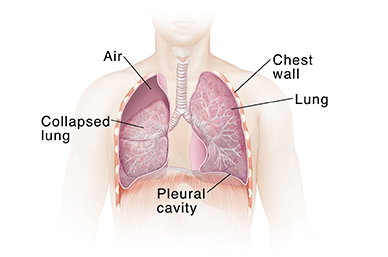

<h1 style="text-align:center;font-size:30px;" > SIIM-ACR Pneumothorax Segmentation </h1>

<h1>1. Business Problem </h1>

<h2> 1.1 Description </h2>

<p> A pneumothorax or collapsed lungs is a medical condition that is responsible for making the people suddenly gasp for air, and feel helplessly breathless for no apparent reason. It can be a complete lung collapse or a collapse of a portion of the lung. It is usually diagnosed by a radiologist with several years of experience on a chest x- ray; which sometimes is very difficult to confirm. 
Our goal is to classify(if present segment) pneumothorax from a set of chest radiographic images.


This is a Kaggle problem. (https://www.kaggle.com/c/siim-acr-pneumothorax-segmentation/overview)
</p>

<h2> 1.2 Problem Statement </h2>

<p> Classify pneumothorax from a set of chest radiographic images and if present segment the regions of pneumnothorax. </p>

<h2> 1.3 Sources </h2>



*   Source : https://www.kaggle.com/c/siim-acr-pneumothorax-segmentation/overview
*   



<h2>1.4 Real world/Business Objectives and Constraints </h2>



*   Classify pneumothorax and if present segment it.
*   Maximize the overlap between the actual mask and predicted mask(Dice).
*   No such latency concerns.



<h1>2. Machine Learning Problem </h1>

<h2> 2.1 Data </h2>

<h3> 2.1.1 Data Overview </h3>

<p> 
- Data is present in under folder SIIM. It contains three folders and files, <br>

*   dicom-images-test
*   dicom-images-train
*   train-rle.csv

Note : I downloaded the data from https://www.kaggle.com/seesee/siim-train-test as the data is removed from the Cloud Healthcare API.
</p>

<h2>2.2 Mapping the real world problem to a Deep Learning Problem </h2>

<h3> 2.2.1 Type of Deep Learning Problem </h3>

<p>It is a basically a semantic image segmentation problem, where we have to segment areas of pneumothorax. </p>

<h3> 2.2.2 Performance Metric </h3>

Source:  https://www.kaggle.com/c/siim-acr-pneumothorax-segmentation/data

Metric: 
* Focal Loss + Dice Loss

  - Focal loss is very good for imbalanced data as it focuses more on hard examples than easy examples. Our data is very imbalanced as the area having pneumothorax is very small. Dice is best metric overall. So we are going for the combination of the two.

<h3> 2.2.3 Necessary Imports </h3>

In [ ]:
import numpy as np

def mask2rle(img, width, height):
    rle = []
    lastColor = 0;
    currentPixel = 0;
    runStart = -1;
    runLength = 0;

    for x in range(width):
        for y in range(height):
            currentColor = img[x][y]
            if currentColor != lastColor:
                if currentColor == 255:
                    runStart = currentPixel;
                    runLength = 1;
                else:
                    rle.append(str(runStart));
                    rle.append(str(runLength));
                    runStart = -1;
                    runLength = 0;
                    currentPixel = 0;
            elif runStart > -1:
                runLength += 1
            lastColor = currentColor;
            currentPixel+=1;

    return " ".join(rle)

def rle2mask(rle, width, height):
    mask= np.zeros(width* height)
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        current_position += start
        mask[current_position:current_position+lengths[index]] = 255
        current_position += lengths[index]

    return mask.reshape(width, height)


In [ ]:
!pip install pydicom

In [ ]:
import pydicom
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import glob
from tqdm import tqdm
import seaborn as sns


import warnings
warnings.filterwarnings("ignore")
import gc
gc.collect()
import cv2
import tensorflow as tf
import keras
from PIL import Image, ImageDraw
from PIL import ImagePath
import imgaug.augmenters as iaa
from skimage import exposure

<h1>3. Exploratory Data Analysis </h1>

In [ ]:
data_rle_train = pd.read_csv("./siim/train-rle.csv")
data_rle_train.head()

,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.6904.151787520...,-1
1,1.2.276.0.7230010.3.1.4.8323329.13666.15178752...,557374 2 1015 8 1009 14 1002 20 997 26 990 32 ...
2,1.2.276.0.7230010.3.1.4.8323329.11028.15178752...,-1
3,1.2.276.0.7230010.3.1.4.8323329.10366.15178752...,514175 10 1008 29 994 30 993 32 991 33 990 34 ...
4,1.2.276.0.7230010.3.1.4.8323329.10016.15178752...,592184 33 976 58 956 73 941 88 926 102 917 109...


In [ ]:
#The second column contains a space infront of it so manually rewriting it
data_rle_train.columns = ['ImageId', 'EncodedPixels']

- train-rle.csv contains the mask information for the images in the train dataset. 
- The column EncodedPixels contains the mask information in rle format.
- Images having no mask i.e. no pneumnothorax have its EncodedPixels value as -1.

In [ ]:
#https://www.kaggle.com/jesperdramsch/intro-chest-xray-dicom-viz-u-nets-full-data
def getInfoDICOM(path, toPrint = False, train = True):

    info = {}

    path = os.path.join(path)
    #reading the data using methods of pydicom
    data = pydicom.dcmread(path)
    info['path'] = path
    info['age'] = data.PatientAge
    info['sex']= data.PatientSex
    info['ImageId'] = data.SOPInstanceUID
    
    if train: #test doesn't have encoded pixels data, we have to predict them
        #SOPInstanceUID contains the storage type which resembles the image ids given in train-rle dataset
        encodedPixels = data_rle_train[data_rle_train['ImageId'] == data.SOPInstanceUID]["EncodedPixels"].values
        info['encodedPixels'] = encodedPixels

        info['lenOfEncodedPixels'] = len(encodedPixels)

        #this is for visualization purpose
        if '-1' in encodedPixels or len(encodedPixels) == 0:
            info['has_pneumothorax'] = 0 
        else:
            info['has_pneumothorax'] = 1
    
    if toPrint:
        print("Path...............:", path)
        print("Patient's Name.....:", data.PatientName)
        print("Patient's Id.......:", data.PatientID)
        print("Patient's Age......:", data.PatientAge)
        print("Patient's Sex......:", data.PatientSex)

        print("Original X Ray")
        plt.figure(figsize=(10,10))
        plt.imshow(data.pixel_array, cmap=plt.cm.bone)
        plt.show()


    return info

Path...............: ./siim/dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.11639.1517875234.49960/1.2.276.0.7230010.3.1.3.8323329.11639.1517875234.49959/1.2.276.0.7230010.3.1.4.8323329.11639.1517875234.49961.dcm
Patient's Name.....: 9b2c32db-d3f8-4033-8083-4f7e906c5a11
Patient's Id.......: 9b2c32db-d3f8-4033-8083-4f7e906c5a11
Patient's Age......: 51
Patient's Sex......: M
Original X Ray


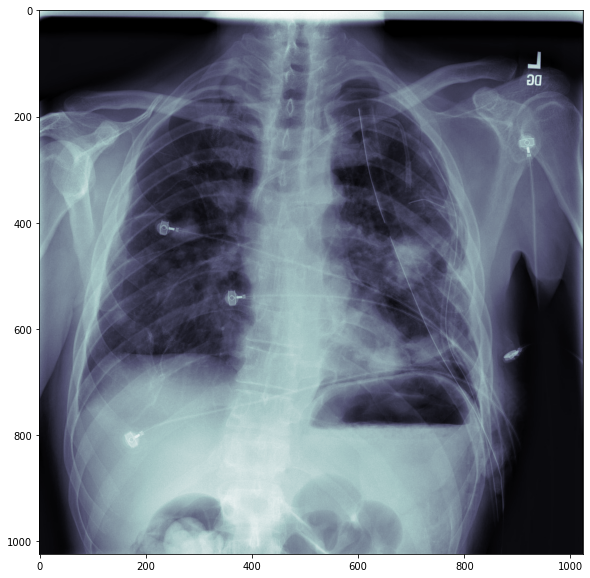

In [ ]:
file_name = './siim/dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.11639.1517875234.49960/1.2.276.0.7230010.3.1.3.8323329.11639.1517875234.49959/1.2.276.0.7230010.3.1.4.8323329.11639.1517875234.49961.dcm'
info = getInfoDICOM(file_name, True, True)

- Every dicom image contains information about the patients.
- Name and id of patients are not readable, they seem to be encrypted for privacy concerns.
- Patients age, sex are also available.
- There are also written text on the images. 

<h3>3.1 Creating train and test dataset </h3>

In [ ]:
#creation of train dataset
#https://stackoverflow.com/questions/33747968/getting-file-list-using-glob-in-python
filesList = glob.glob('./siim/dicom-images-train/*/*/*.dcm')
train = pd.DataFrame()
train_list = []
for file in tqdm(filesList):
    info = getInfoDICOM(file, False, True)
    train_list.append(info)
train = pd.DataFrame(train_list)

100%|██████████| 12089/12089 [00:24<00:00, 486.91it/s]


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12089 entries, 0 to 12088
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   path                12089 non-null  object
 1   age                 12089 non-null  object
 2   sex                 12089 non-null  object
 3   ImageId             12089 non-null  object
 4   encodedPixels       12089 non-null  object
 5   lenOfEncodedPixels  12089 non-null  int64 
 6   has_pneumothorax    12089 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 661.2+ KB


In [ ]:
train.head(5)

,path,age,sex,ImageId,encodedPixels,lenOfEncodedPixels,has_pneumothorax
0,./siim/dicom-images-train/1.2.276.0.7230010.3....,30,F,1.2.276.0.7230010.3.1.4.8323329.4185.151787518...,[568459 5 1014 9 1011 13 1008 15 1006 17 1004 ...,1,1
1,./siim/dicom-images-train/1.2.276.0.7230010.3....,46,M,1.2.276.0.7230010.3.1.4.8323329.14269.15178752...,[-1],1,0
2,./siim/dicom-images-train/1.2.276.0.7230010.3....,66,M,1.2.276.0.7230010.3.1.4.8323329.3552.151787517...,[-1],1,0
3,./siim/dicom-images-train/1.2.276.0.7230010.3....,19,F,1.2.276.0.7230010.3.1.4.8323329.5298.151787518...,[-1],1,0
4,./siim/dicom-images-train/1.2.276.0.7230010.3....,72,F,1.2.276.0.7230010.3.1.4.8323329.2137.151787517...,[-1],1,0


In [ ]:
#creation of test dataset
filesList = glob.glob('./siim/dicom-images-test/*/*/*.dcm')
test = pd.DataFrame()
test_list = []
for file in tqdm(filesList):
    info = getInfoDICOM(file, False, False)
    test_list.append(info)
test = pd.DataFrame(test_list)

100%|██████████| 3205/3205 [00:02<00:00, 1291.75it/s]


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3205 entries, 0 to 3204
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   path     3205 non-null   object
 1   age      3205 non-null   object
 2   sex      3205 non-null   object
 3   ImageId  3205 non-null   object
dtypes: object(4)
memory usage: 100.3+ KB


In [ ]:
test.head(5)

,path,age,sex,ImageId
0,./siim/dicom-images-test/_/_/ID_29804aff4.dcm,82,F,ID_29804aff4
1,./siim/dicom-images-test/_/_/ID_bf534a6ee.dcm,54,M,ID_bf534a6ee
2,./siim/dicom-images-test/_/_/ID_733f72db6.dcm,64,F,ID_733f72db6
3,./siim/dicom-images-test/_/_/ID_cde4075de.dcm,23,M,ID_cde4075de
4,./siim/dicom-images-test/_/_/ID_3b95d7640.dcm,40,F,ID_3b95d7640


<h3> 3.2 Checking if there are any null values and replacing them </h3>

In [ ]:
print("Columns having null values in train", train.columns[train.isnull().any()].tolist())

Columns having null values in train []


In [ ]:
print("No of images having no mask", train[train['lenOfEncodedPixels'] == 0].shape[0])

No of images having no mask 42


- There are 42 rows where the images doesn't have any mask.
- We can assume that these images don't have have pneumothorax.

In [ ]:
train.loc[train.lenOfEncodedPixels == 0 , 'encodedPixels'] = np.array(-1)

<h3> 3.3 Visualizing the mask </h3>

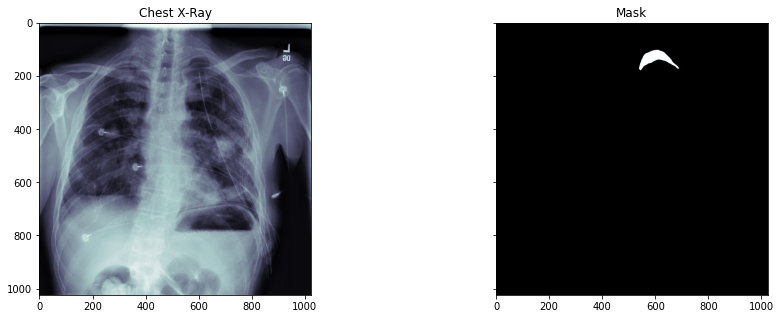

In [ ]:
file_name = './siim/dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.11639.1517875234.49960/1.2.276.0.7230010.3.1.3.8323329.11639.1517875234.49959/1.2.276.0.7230010.3.1.4.8323329.11639.1517875234.49961.dcm'
path = os.path.join(file_name)
#reading the data using pydicom
data = pydicom.dcmread(path)


encodedPixels = data_rle_train[data_rle_train['ImageId'] == data.SOPInstanceUID]["EncodedPixels"].values
mask = np.zeros((1024, 1024))
for pix in encodedPixels:
    mask = mask + rle2mask(pix, 1024, 1024).T
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15,5))
ax[0].imshow(data.pixel_array, cmap=plt.cm.bone)
ax[0].set_title('Chest X-Ray')

ax[1].imshow(mask, cmap=plt.cm.bone)
ax[1].set_title('Mask')
plt.show()


- It is very difficult to make out from the picture what really constitutes of pneumothorax.

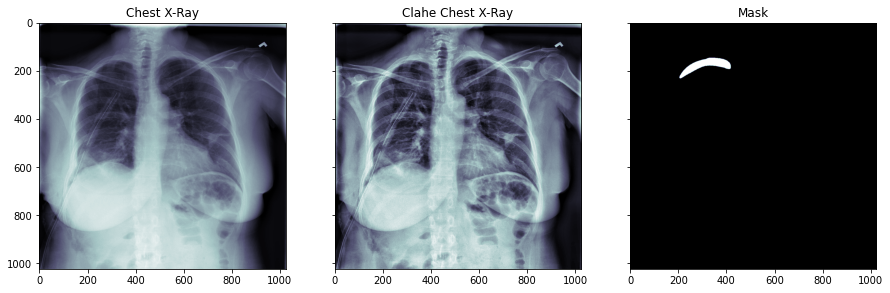

In [ ]:
file_name = './siim/dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.10005.1517875220.958950/1.2.276.0.7230010.3.1.3.8323329.10005.1517875220.958949/1.2.276.0.7230010.3.1.4.8323329.10005.1517875220.958951.dcm'
path = os.path.join(file_name)
#reading the data using pydicom
data = pydicom.dcmread(path)

encodedPixels = data_rle_train[data_rle_train['ImageId'] == data.SOPInstanceUID]["EncodedPixels"].values
mask = np.zeros((1024, 1024))
for pix in encodedPixels:
    mask = mask + rle2mask(pix, 1024, 1024).T

fig, ax = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(15,5))
ax[0].imshow(data.pixel_array, cmap=plt.cm.bone)
ax[0].set_title('Chest X-Ray')

#Using clahe to make it somewhat visible
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(16, 16))
clahe_pixel_array = clahe.apply(data.pixel_array)
ax[1].imshow(clahe_pixel_array, cmap=plt.cm.bone)
ax[1].set_title('Clahe Chest X-Ray')

ax[2].imshow(mask, cmap=plt.cm.bone)
ax[2].set_title('Mask')
plt.show()


<h3> 3.3 Analysis on data </h3>

In [ ]:
train['has_pneumothorax'].value_counts()

0    9420
1    2669
Name: has_pneumothorax, dtype: int64

- Out of 12089 images 2669 contains pneumothorax.

In [ ]:
train['sex'].value_counts()

M    6650
F    5439
Name: sex, dtype: int64

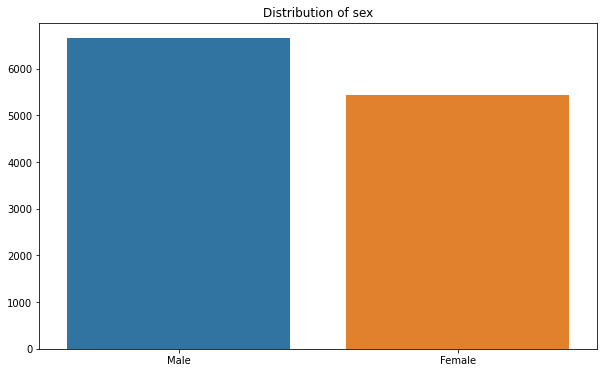

In [ ]:
x = ["Male" , "Female"]
y = [train['sex'].value_counts()[0] , train['sex'].value_counts()[1]]
plt.figure(figsize=(10, 6))
plt.title("Distribution of sex")
sns.barplot(x,y)
plt.show()

- More data is present for the male population

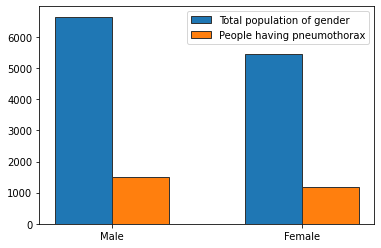

In [ ]:
x = np.array(['Male', 'Female'])
plt.bar(x, [len(train[(train['sex'] == 'M')]), len(train[(train['sex'] == 'F')])], width=-0.3, align='edge', label='Total population of gender', edgecolor=[0.2]*3)
plt.bar(x, [len(train[(train['has_pneumothorax']==1) & (train['sex'] == 'M')]), len(train[(train['has_pneumothorax']==1) & (train['sex'] == 'F')])], width=0.3, align='edge', label='People having pneumothorax', edgecolor=[0.2]*3)
plt.legend()
plt.show()

- Out of total population of a particular gender many of them don't have pneumothorax

In [ ]:
print("Out of total male population {} % of them have pneumothorax".format((len(train[(train['has_pneumothorax']==1) & (train['sex'] == 'M')])/len(train[train['sex'] == 'M']))*100))

Out of total male population 22.39097744360902 % of them have pneumothorax


In [ ]:
print("Out of total female population {} % of them have pneumothorax".format((len(train[(train['has_pneumothorax']==1) & (train['sex'] == 'F')])/len(train[train['sex'] == 'F']))*100))

Out of total female population 21.695164552307407 % of them have pneumothorax


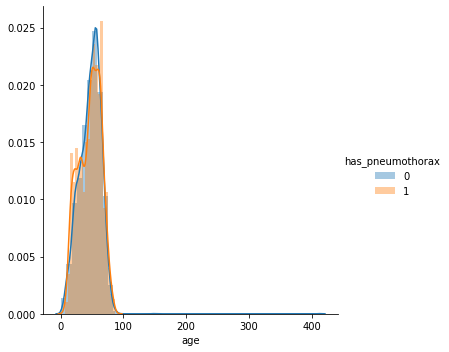

In [ ]:
sns.FacetGrid(train, hue="has_pneumothorax", size=5) \
 .map(sns.distplot, "age") \
 .add_legend();
plt.show();

- It seems that pneumothorax is not depended on age.

In [ ]:
print("Patient having maximum age {}".format(train['age'].max()))

Patient having maximum age 94


In [ ]:
print("Patient having minimum age {}".format(train['age'].min()))

Patient having minimum age 1


<h1> 4. Data Preparation </h1>

In [ ]:
def computeMasks(train, path):
    mask_paths = []
    for index, row in tqdm(train.iterrows()):
        pixels = row['encodedPixels']
        mask = np.zeros((1024, 1024))
        if row['has_pneumothorax'] == 1:          
            for pix in pixels:
                mask = mask + rle2mask(pix, 1024, 1024).T       
        img = Image.fromarray(mask).convert('L')
        path2save = path + str(index+1) + ".jpg"
        img.save(path2save)
        mask_paths.append(path2save)
    train["mask"] = mask_paths
    return train

In [ ]:
path = "siim/dicom-mask-train/"
try:
    os.makedirs(path)
except:
    pass
train = computeMasks(train, path)
train.head(2)

12089it [04:41, 42.89it/s]


,path,age,sex,ImageId,encodedPixels,lenOfEncodedPixels,has_pneumothorax,mask
0,./siim/dicom-images-train/1.2.276.0.7230010.3....,63,M,1.2.276.0.7230010.3.1.4.8323329.11956.15178752...,[-1],1,0,siim/dicom-mask-train/1.jpg
1,./siim/dicom-images-train/1.2.276.0.7230010.3....,19,M,1.2.276.0.7230010.3.1.4.8323329.3534.151787517...,[-1],1,0,siim/dicom-mask-train/2.jpg


In [ ]:
def convertImagesToJpeg(train, path):
    images_paths = []
    for index, row in tqdm(train.iterrows()):
        path2dicom = row['path']
        ds = pydicom.read_file(path2dicom) # read dicom image
        img = ds.pixel_array # get image array
        img_mem = Image.fromarray(img) # Creates an image memory from an object exporting the array interface
        path2save = path + str(index + 1)  + ".jpg"
        img_mem.save(path2save)
        images_paths.append(path2save)
    train["images_paths"] = images_paths
    return train

In [ ]:
path = "siim/dicom-images-train-jpg/"
try:
    os.makedirs(path)
except:
    pass
train = convertImagesToJpeg(train, path)
train.head(2)

12089it [04:32, 44.42it/s]


,path,age,sex,ImageId,encodedPixels,lenOfEncodedPixels,has_pneumothorax,mask,images_paths
0,./siim/dicom-images-train/1.2.276.0.7230010.3....,63,M,1.2.276.0.7230010.3.1.4.8323329.11956.15178752...,[-1],1,0,siim/dicom-mask-train/1.jpg,siim/dicom-images-train-jpg/1.jpg
1,./siim/dicom-images-train/1.2.276.0.7230010.3....,19,M,1.2.276.0.7230010.3.1.4.8323329.3534.151787517...,[-1],1,0,siim/dicom-mask-train/2.jpg,siim/dicom-images-train-jpg/2.jpg


In [ ]:
path = "siim/dicom-images-test-jpg/"
try:
    os.makedirs(path)
except:
    pass
test = convertImagesToJpeg(test, path)
test.head(2)

3205it [01:12, 44.49it/s]


,path,age,sex,ImageId,images_paths
0,./siim/dicom-images-test/_/_/ID_213b7e68f.dcm,29,M,ID_213b7e68f,siim/dicom-images-test-jpg/1.jpg
1,./siim/dicom-images-test/_/_/ID_f0bbc61c9.dcm,47,M,ID_f0bbc61c9,siim/dicom-images-test-jpg/2.jpg


<h1>5. Data Pipeline</h1>

In [ ]:
import tensorflow as tf
# tf.compat.v1.enable_eager_execution()
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Multiply
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform, he_normal
from tensorflow.keras.losses import binary_crossentropy
K.set_image_data_format('channels_last')

In [ ]:
img_size = 256

In [ ]:
def load_data(data):
    images = data['images_paths']
    masks = data['mask']
    return images, masks


def read_image(datapoint):
    image = tf.keras.preprocessing.image.load_img(datapoint)
    image = tf.keras.preprocessing.image.img_to_array(image, dtype='float32')
    image = tf.image.resize(image, [img_size, img_size])
    image = image / 255.0
    image = exposure.equalize_adapthist(image)     # contrast correction
    return image

def read_mask(datapoint):
    mask = tf.keras.preprocessing.image.load_img(datapoint, color_mode='grayscale')
    mask = tf.keras.preprocessing.image.img_to_array(mask, dtype = 'float32')
    mask = tf.image.resize(mask, [img_size, img_size])
    mask = mask / 255.0
    return mask
    
def preprocess(image, image_mask):
    def f(image, image_mask):

        image = image.decode()
        image_mask = image_mask.decode()

        image = read_image(image)
        image_mask = read_mask(image_mask)

        a = np.random.uniform()
        if a<0.50:
            image = tf.image.flip_left_right(image)
            image_mask = tf.image.flip_left_right(image_mask)
        else:
            image = tf.image.flip_up_down(image)
            image_mask = tf.image.flip_up_down(image_mask)

        return image, image_mask
    images, masks = tf.numpy_function(f, [image, image_mask], [tf.float32, tf.float32])
    images.set_shape([img_size, img_size, 3])
    masks.set_shape([img_size, img_size, 1])

    return images, masks

def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.shuffle(buffer_size=15000)
    dataset = dataset.map(preprocess)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(2)
    return dataset

In [ ]:
def display(display_list):
    plt.figure(figsize=(8, 8))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [ ]:
def load_data_for_predict(data):
    images = data['images_paths']
    image_id = data['ImageId']
    return images, image_id

def preprocess_predict(image, image_id):
    def f(image, image_id):

        image = image.decode()
        image_id = image_id.decode()

        image = read_image(image)

        return image, image_id

    images, imageid = tf.numpy_function(f, [image, image_id], [tf.float32, tf.string])
    images.set_shape([img_size, img_size, 3])

    return images, image_id

def tf_dataset_predict(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.shuffle(buffer_size=15000)
    dataset = dataset.map(preprocess_predict)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(2)
    return dataset

<h1>6. Model </h1>

1. Here i will be taking only the pneumothorax data as the dataset is severly imbalanced.

In [ ]:
only_pnemothorax = train[train['has_pneumothorax'] == 1]

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(only_pnemothorax, test_size=0.10, random_state=42)

In [ ]:
X_train.head(2)

,path,age,sex,ImageId,encodedPixels,lenOfEncodedPixels,has_pneumothorax,mask,images_paths
835,./siim/dicom-images-train/1.2.276.0.7230010.3....,73,F,1.2.276.0.7230010.3.1.4.8323329.11383.15178752...,[334101 2 1020 3 1019 4 1018 5 1016 6 1016 7 1...,1,1,siim/dicom-mask-train/836.jpg,siim/dicom-images-train-jpg/836.jpg
10336,./siim/dicom-images-train/1.2.276.0.7230010.3....,42,F,1.2.276.0.7230010.3.1.4.8323329.1460.151787516...,[818450 23 998 30 994 34 990 39 986 39 986 39 ...,2,1,siim/dicom-mask-train/10337.jpg,siim/dicom-images-train-jpg/10337.jpg


In [ ]:
images, masks = load_data(X_train)
train_dataset = tf_dataset(images, masks, 8)

images, masks = load_data(X_test)
test_dataset = tf_dataset(images, masks, 8)

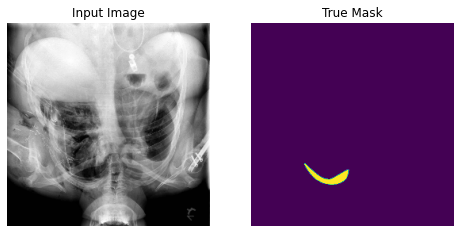

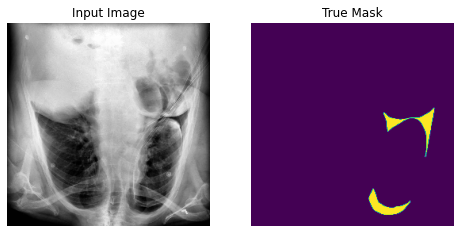

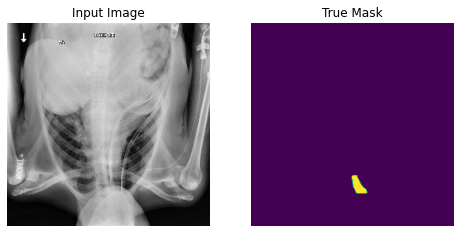

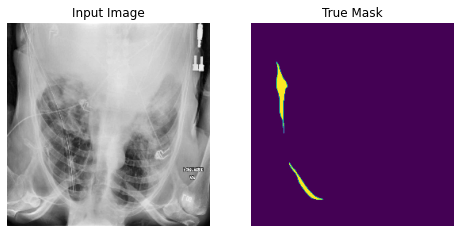

In [ ]:
for image, mask in train_dataset.take(1):
    sample_image, sample_mask = image, mask
for i in range(4):
    display([sample_image[i], sample_mask[i]])

In [ ]:
class BasicBlock(tf.keras.layers.Layer):

    def __init__(self, filters, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1_basic = Conv2D(filters=filters, kernel_size=(3, 3),strides=stride, padding="same", activation = "relu")
        self.batchNorm1_basic = BatchNormalization()
        self.conv2_basic = Conv2D(filters=filters,kernel_size=(3, 3),strides=1,padding="same", activation = "relu")
        self.batchNorm2_basic = BatchNormalization()
        if stride != 1:
            self.downsample_basic = tf.keras.Sequential()
            self.downsample_basic.add(Conv2D(filters=filters, kernel_size=(1, 1), strides=stride,  activation = "relu"))
            self.downsample_basic.add(BatchNormalization())
        else:
            self.downsample_basic = lambda x: x

    def call(self, inputs, training=None, **kwargs):
        residual = self.downsample_basic(inputs)

        x = self.conv1_basic(inputs)
        x = self.batchNorm1_basic(x, training=training)
        x = tf.nn.relu(x)
        x = self.conv2_basic(x)
        x = self.batchNorm2_basic(x, training=training)

        output = tf.nn.relu(tf.keras.layers.add([residual, x]))

        return output

def make_basic_block_layer(filter_num, blocks, stride=1):
    res_block = tf.keras.Sequential()
    res_block.add(BasicBlock(filter_num, stride=stride))

    for _ in range(1, blocks):
        res_block.add(BasicBlock(filter_num, stride=1))

    return res_block


In [ ]:
class UNETBlock(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.conv1_unet = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')
        self.conv1_1_unet = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')
        self.conv1_2_unet = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')
        self.conv1_3_unet = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')

        self.pool1_unet = MaxPooling2D(pool_size=(2, 2))

        self.conv2_unet = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')
        self.conv2_1_unet = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')
        self.conv2_2_unet = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')
        self.conv2_3_unet = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')

        self.conv3_unet = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')
        self.conv3_1_unet = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')
        self.conv3_2_unet = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')
        self.conv3_3_unet = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')

        self.conv4_unet = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')
        self.conv4_1_unet = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')
        self.conv4_2_unet = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')
        self.conv4_3_unet = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')

        self.drop1_unet = Dropout(0.2)
        self.conv5_unet = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')
        self.conv5_1_unet = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')

        self.up1_unet = UpSampling2D(size = (2,2))
        self.conv6_unet = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')
        self.conv6_1_unet = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')
        
        self.conv7_unet = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')
        self.conv8_unet = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')
        self.conv9_unet = Conv2D(16, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')
        self.conv10_unet = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')
        self.conv11_unet = Conv2D(1, 1, activation = 'sigmoid')
    
    def call(self, inputs):
        x = self.conv1_unet(inputs)
        conv_1 = self.conv1_1_unet(x)
        x = self.pool1_unet(conv_1)
        x = self.conv2_unet(x)
        conv_2 = self.conv2_1_unet(x)
        x = self.pool1_unet(x)
        x = self.conv3_unet(x)
        conv_3 = self.conv3_1_unet(x)
        x = self.pool1_unet(conv_3)
        x = self.conv4_unet(x)
        x = self.conv4_1_unet(x)
        drop_1 = self.drop1_unet(x)
        x = self.pool1_unet(drop_1)
        
        x = self.conv5_unet(x)
        x = self.conv5_1_unet(x)
        drop_2 = self.drop1_unet(x)
        
        x = self.conv6_unet(self.up1_unet(drop_2))
        x = concatenate([drop_1, x], axis = -1)

        x = self.conv4_2_unet(x)
        x = self.conv4_3_unet(x)
        
        x = self.conv7_unet(self.up1_unet(x))
        x = concatenate([conv_3, x], axis = -1)
        x = self.conv3_2_unet(x)
        x = self.conv3_3_unet(x)
        
        x = self.conv8_unet(self.up1_unet(x))
        x = concatenate([conv_2, x], axis = -1)
        x = self.conv2_2_unet(x)
        x = self.conv2_3_unet(x)
        
        x = self.conv9_unet(self.up1_unet(x))
        x = self.conv1_2_unet(x)
        x = self.conv1_3_unet(x)
        x = self.conv10_unet(x)
        output = self.conv11_unet(x)
        
        return output
                                   

In [ ]:
class UnetResnet34(tf.keras.Model):
    def __init__(self, input_shape, layer_params):
        super().__init__()

        self.conv1_resnet = tf.keras.layers.Conv2D(filters=32,
                                            kernel_size=(7, 7),
                                            strides=2,
                                            padding="same")
        self.bn1_resnet = tf.keras.layers.BatchNormalization()
        self.pool1_resnet = tf.keras.layers.MaxPool2D(pool_size=(3, 3),
                                               strides=2,
                                               padding="same")

        self.layer1_resnet = make_basic_block_layer(filter_num=32,
                                             blocks=layer_params[0])
        self.layer2_resnet = make_basic_block_layer(filter_num=64,
                                             blocks=layer_params[1],
                                             stride=2)
        self.layer3_resnet = make_basic_block_layer(filter_num=128,
                                             blocks=layer_params[2],
                                             stride=2)
        self.layer4_resnet = make_basic_block_layer(filter_num=256,
                                             blocks=layer_params[3],
                                             stride=2)

        self.avgpool_resnet = tf.keras.layers.AveragePooling2D()
        
        self.unetBlock_resnet = UNETBlock()
        
        self.upsample_resnet = tf.keras.layers.UpSampling2D(size = (64, 64))
        self.conv1_resize = tf.keras.layers.Conv2D(filters=1,
                                            kernel_size=(3, 3),
                                            strides=1,
                                            padding="same")
        

    def call(self, inputs, training=None, mask=None):
        x = self.conv1_resnet(inputs)
        x = self.bn1_resnet(x, training=training)
        x = tf.nn.relu(x)
        x = self.pool1_resnet(x)
        x = self.layer1_resnet(x, training=training)
        x = self.layer2_resnet(x, training=training)
        x = self.layer3_resnet(x, training=training)
        x = self.layer4_resnet(x, training=training)
        x = self.avgpool_resnet(x)
        x = self.upsample_resnet(x)
        x = self.conv1_resize(x)
        output = self.unetBlock_resnet(x)

        return output

In [ ]:
model = UnetResnet34((256, 256, 3),[3, 4, 6, 3])

In [ ]:
smooth = 1e-5
def dice_coef(y_true, y_pred):
    y_true_f = tf.keras.layers.Flatten()(y_true)
    y_pred_f = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)


def combined_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred) + binary_crossentropy(y_true, y_pred)

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('./best_model1.h5', save_weights_only=True, save_best_only=True, \
                                       mode='min'),
]

In [ ]:
optim = tf.keras.optimizers.Adam(0.001)

metrics=[dice_coef]
loss = combined_loss 

model.compile(optim, loss , metrics)

In [ ]:
history = model.fit(train_dataset, steps_per_epoch=len(train_dataset), epochs=70,\
                              validation_data=test_dataset,callbacks=callbacks, )

Epoch 1/70
301/301 [==============================] - 197s 636ms/step - loss: 1.1040 - dice_coef: 0.0287 - val_loss: 1.3833 - val_dice_coef: 0.0284
Epoch 2/70
301/301 [==============================] - 191s 634ms/step - loss: 1.0159 - dice_coef: 0.0715 - val_loss: 1.0209 - val_dice_coef: 0.0772
Epoch 3/70
301/301 [==============================] - 194s 644ms/step - loss: 1.0069 - dice_coef: 0.0812 - val_loss: 1.2060 - val_dice_coef: 0.0582
Epoch 4/70
301/301 [==============================] - 196s 653ms/step - loss: 0.9938 - dice_coef: 0.0967 - val_loss: 1.0358 - val_dice_coef: 0.0868
Epoch 5/70
301/301 [==============================] - 193s 642ms/step - loss: 0.9861 - dice_coef: 0.1040 - val_loss: 0.9912 - val_dice_coef: 0.0889
Epoch 6/70
301/301 [==============================] - 192s 637ms/step - loss: 0.9702 - dice_coef: 0.1178 - val_loss: 1.0163 - val_dice_coef: 0.0625
Epoch 7/70
301/301 [==============================] - 190s 632ms/step - loss: 0.9632 - dice_coef: 0.1258 - val_l

In [ ]:
#Saving this model as it is showing better results
model.save("pneumothorax_predictor")

INFO:tensorflow:Assets written to: pneumothorax_predictor/assets


INFO:tensorflow:Assets written to: pneumothorax_predictor/assets


In [ ]:
#zipping so that it can be downloaded in colab
!zip -r /content/pneumothorax_predictor.zip /content/pneumothorax_predictor/

  adding: content/pneumothorax_predictor/ (stored 0%)
  adding: content/pneumothorax_predictor/variables/ (stored 0%)
  adding: content/pneumothorax_predictor/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/pneumothorax_predictor/variables/variables.index (deflated 80%)
  adding: content/pneumothorax_predictor/assets/ (stored 0%)
  adding: content/pneumothorax_predictor/saved_model.pb (deflated 91%)


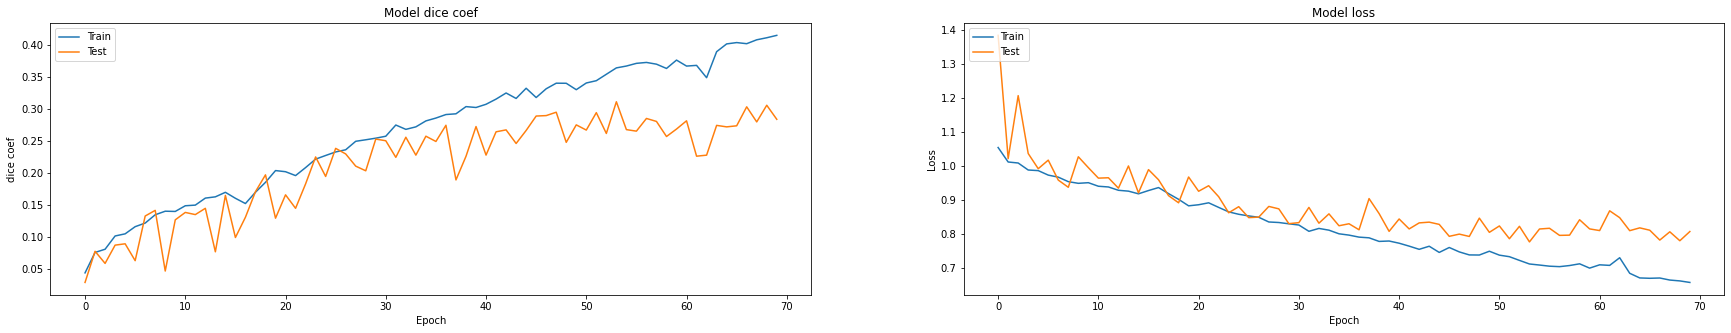

In [ ]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('Model dice coef')
plt.ylabel('dice coef')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

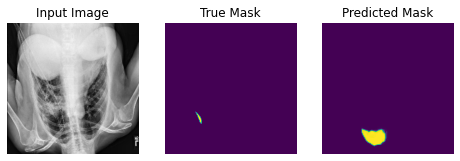

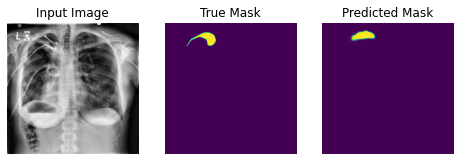

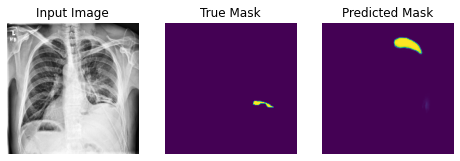

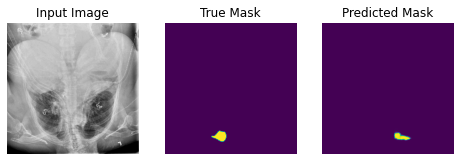

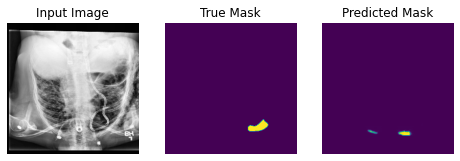

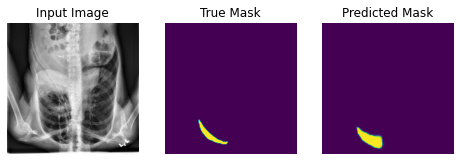

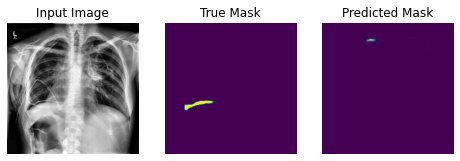

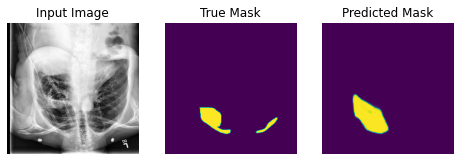

In [ ]:
for image, mask in train_dataset.take(1):
    sample_image, sample_mask = image, mask
    pred_masks = model.predict(sample_image)
    for i in range(8):
        display([sample_image[i], sample_mask[i], pred_masks[i]])

In [ ]:
images , imageid = load_data_for_predict(test)
test_sub = tf_dataset_predict(images, imageid)

In [ ]:
submission = []
for image, imageid in test_sub:
    pred_masks = model.predict(image)
    for i in range(len(pred_masks)):
        prediction = {}
        prediction['ImageId'] = imageid[i].numpy().decode()
        pred_masks[i] = (pred_masks[i] > .5).astype(int)
    
        if pred_masks[i].sum() < 1:
            prediction['EncodedPixels'] =  -1
        else:
            prediction['EncodedPixels'] = mask2rle(pred_masks[i] * 255, 256, 256)

        submission.append(prediction)

In [ ]:
submission_df = pd.DataFrame(submission)
submission_df = submission_df[['ImageId','EncodedPixels']]
submission_df.head()

,ImageId,EncodedPixels
0,ID_62d18c79f,11935 20 233 25 228 30 225 31 224 33 221 37 21...
1,ID_5c658c92c,5217 10 245 13 241 16 239 18 237 19 236 20 236...
2,ID_19cceaa1a,10138 15 239 18 237 21 233 25 230 29 226 31 22...
3,ID_88371969e,10142 16 237 21 234 24 231 27 228 29 227 30 22...
4,ID_474682dd8,43724 2 254 2 254 3 252 4 252 4 253 4 252 4 25...


<h3> 2. Here i am taking data equally from both these two datasets and also i having am the model using the weights i learned from my previous model. </h3>

In [ ]:
pneumothorax_data = train[train['has_pneumothorax'] == 1]
non_pneumothorax_data = train[train['has_pneumothorax'] != 1]
non_pneumothorax_data = non_pneumothorax_data.sample(3000)
new_dataset = pd.concat([pneumothorax_data,non_pneumothorax_data],axis = 0)
new_dataset.head(2)

,path,age,sex,ImageId,encodedPixels,lenOfEncodedPixels,has_pneumothorax,mask,images_paths
7,./siim/dicom-images-train/1.2.276.0.7230010.3....,52,F,1.2.276.0.7230010.3.1.4.8323329.2421.151787517...,[336085 9 1014 11 1011 13 1009 16 1006 18 1005...,1,1,siim/dicom-mask-train/8.jpg,siim/dicom-images-train-jpg/8.jpg
12,./siim/dicom-images-train/1.2.276.0.7230010.3....,31,F,1.2.276.0.7230010.3.1.4.8323329.32430.15178751...,[82496 29 987 50 970 60 957 72 945 81 936 91 9...,1,1,siim/dicom-mask-train/13.jpg,siim/dicom-images-train-jpg/13.jpg


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(new_dataset, test_size=0.10, random_state=42)

In [ ]:
X_train.head(2)

,path,age,sex,ImageId,encodedPixels,lenOfEncodedPixels,has_pneumothorax,mask,images_paths
8281,./siim/dicom-images-train/1.2.276.0.7230010.3....,61,M,1.2.276.0.7230010.3.1.4.8323329.6177.151787519...,[561237 8 1011 17 1004 22 1000 26 996 28 995 2...,1,1,siim/dicom-mask-train/8282.jpg,siim/dicom-images-train-jpg/8282.jpg
5902,./siim/dicom-images-train/1.2.276.0.7230010.3....,49,F,1.2.276.0.7230010.3.1.4.8323329.1615.151787516...,[-1],1,0,siim/dicom-mask-train/5903.jpg,siim/dicom-images-train-jpg/5903.jpg


In [ ]:
images, masks = load_data(X_train)
train_dataset = tf_dataset(images, masks, 8)

images, masks = load_data(X_test)
test_dataset = tf_dataset(images, masks, 8)

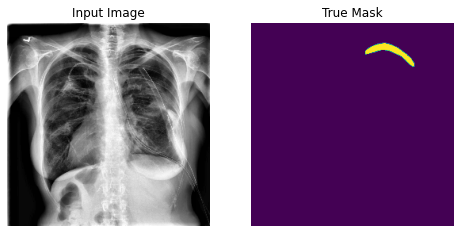

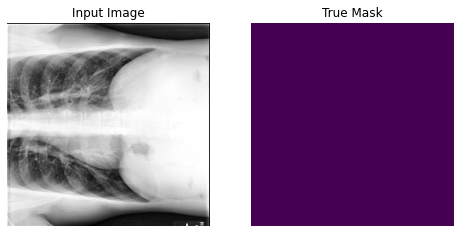

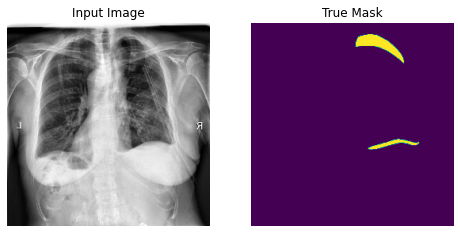

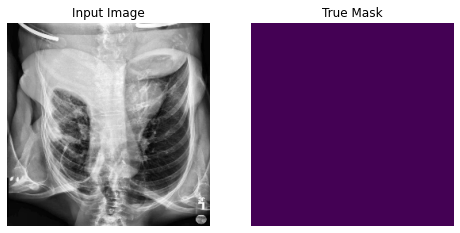

In [ ]:
for image, mask in train_dataset.take(1):
    sample_image, sample_mask = image, mask
for i in range(4):
    display([sample_image[i], sample_mask[i]])

In [ ]:
model2 = UnetResnet34((256, 256, 3),[3, 4, 6, 3])

In [ ]:
smooth = 1e-5
def dice_coef(y_true, y_pred):
    y_true_f = tf.keras.layers.Flatten()(y_true)
    y_pred_f = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)


def combined_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred) + binary_crossentropy(y_true, y_pred)

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('./best_model2.h5', save_weights_only=True, save_best_only=True, \
                                       mode='min'),
   tf.keras.callbacks.ReduceLROnPlateau(patience = 10, min_lr= 0.000001)
]

In [ ]:
optim = tf.keras.optimizers.Adam(0.0001)

metrics=[dice_coef]
loss = combined_loss 

model2.compile(optim, loss , metrics)

In [ ]:
model2.fit(train_dataset, steps_per_epoch=len(train_dataset), epochs=1,\
                              validation_data=test_dataset,callbacks=callbacks, )

638/638 [==============================] - 411s 623ms/step - loss: 1.9094 - dice_coef: 0.0129 - val_loss: 1.6517 - val_dice_coef: 0.0119


In [ ]:
#Loading weights from the previous model
model2.load_weights("best_model1.h5")

In [ ]:
history2 = model2.fit(train_dataset, steps_per_epoch=len(train_dataset), epochs=25,\
                              validation_data=test_dataset,callbacks=callbacks, )

Epoch 1/25
638/638 [==============================] - 408s 640ms/step - loss: 0.7660 - dice_coef: 0.2784 - val_loss: 0.7106 - val_dice_coef: 0.3281
Epoch 2/25
638/638 [==============================] - 408s 639ms/step - loss: 0.7542 - dice_coef: 0.2896 - val_loss: 0.7386 - val_dice_coef: 0.3000
Epoch 3/25
638/638 [==============================] - 409s 641ms/step - loss: 0.7420 - dice_coef: 0.3014 - val_loss: 0.7274 - val_dice_coef: 0.3118
Epoch 4/25
638/638 [==============================] - 410s 642ms/step - loss: 0.7332 - dice_coef: 0.3098 - val_loss: 0.6989 - val_dice_coef: 0.3415
Epoch 5/25
638/638 [==============================] - 407s 638ms/step - loss: 0.7216 - dice_coef: 0.3212 - val_loss: 0.7086 - val_dice_coef: 0.3294
Epoch 6/25
638/638 [==============================] - 405s 634ms/step - loss: 0.7218 - dice_coef: 0.3208 - val_loss: 0.7035 - val_dice_coef: 0.3346
Epoch 7/25
638/638 [==============================] - 405s 634ms/step - loss: 0.7119 - dice_coef: 0.3303 - val_l

In [ ]:
model2.summary()

Model: "unet_resnet34_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_62 (Conv2D)           multiple                  4736      
_________________________________________________________________
batch_normalization_36 (Batc multiple                  128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 multiple                  0         
_________________________________________________________________
sequential_7 (Sequential)    (None, 64, 64, 32)        56256     
_________________________________________________________________
sequential_8 (Sequential)    (None, 32, 32, 64)        281408    
_________________________________________________________________
sequential_10 (Sequential)   (None, 16, 16, 128)       1712256   
_________________________________________________________________
sequential_12 (Sequential)   (None, 8, 8, 256)     

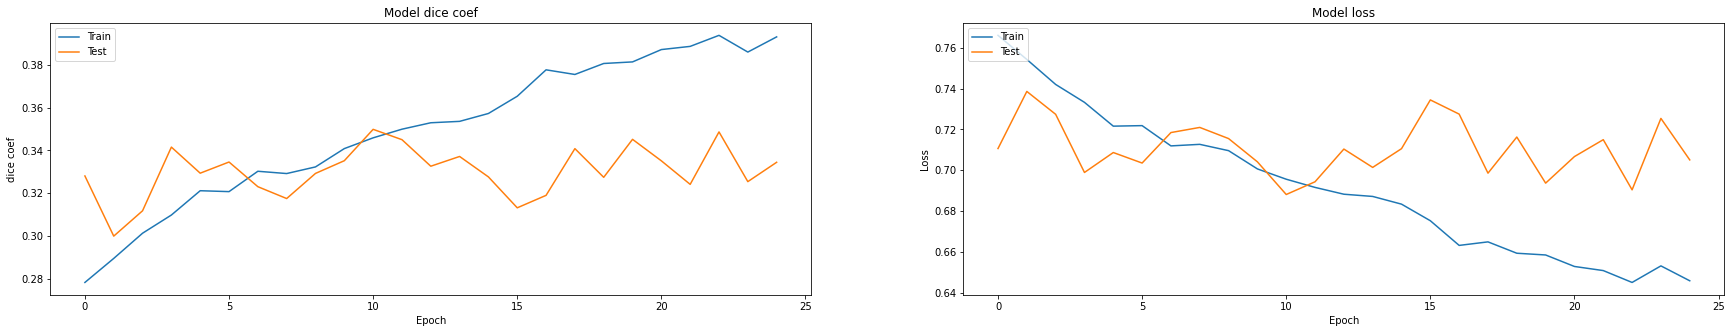

In [ ]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history2.history['dice_coef'])
plt.plot(history2.history['val_dice_coef'])
plt.title('Model dice coef')
plt.ylabel('dice coef')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

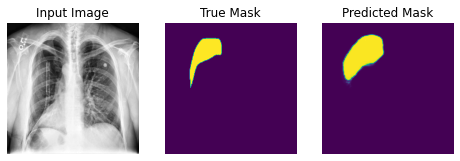

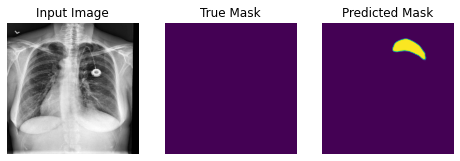

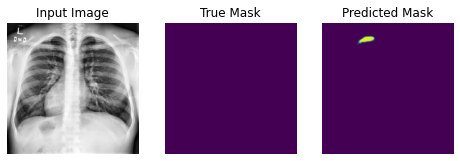

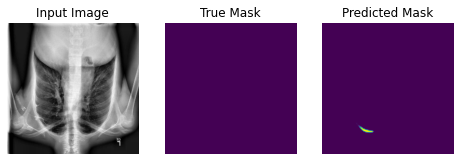

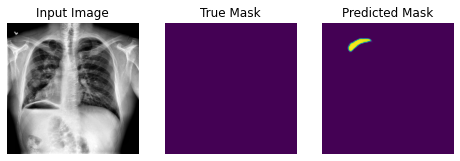

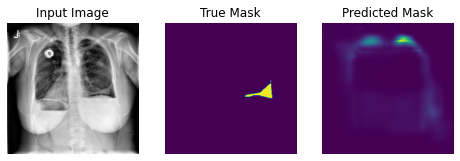

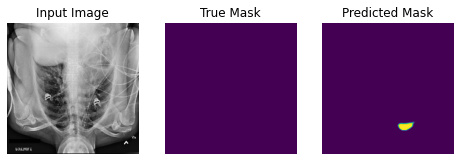

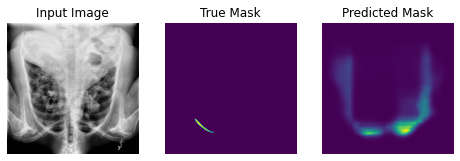

In [ ]:
for image, mask in train_dataset.take(1):
    sample_image, sample_mask = image, mask
    pred_masks = model2.predict(sample_image)
    for i in range(8):
        display([sample_image[i], sample_mask[i], pred_masks[i]])

In [ ]:
images , imageid = load_data_for_predict(test)
test_sub = tf_dataset_predict(images, imageid)

In [ ]:
submission = []
for image, imageid in test_sub:
    pred_masks = model2.predict(image)
    for i in range(len(pred_masks)):
        prediction = {}
        prediction['ImageId'] = imageid[i].numpy().decode()
        pred_masks[i] = (pred_masks[i] > .5).astype(int)
    
        if pred_masks[i].sum() < 1:
            prediction['EncodedPixels'] =  -1
        else:
            prediction['EncodedPixels'] = mask2rle(pred_masks[i] * 255, 256, 256)

        submission.append(prediction)

In [ ]:
submission_df = pd.DataFrame(submission)
submission_df = submission_df[['ImageId','EncodedPixels']]
submission_df.head()

,ImageId,EncodedPixels
0,ID_73c53cd54,-1
1,ID_b4480fd55,7568 14 239 22 233 26 229 30 225 33 223 35 221...
2,ID_8dbfc31c5,-1
3,ID_2251f0828,4700 10 243 15 238 21 231 26 228 29 225 32 223...
4,ID_636060bd7,-1
